In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def fun_getNeutronEnergyVSEmissionAngle(energy, angle):
    # returns xRad,y,angle,intp_Y_av : xRad is the angle in radian for the formula, y is the neutron energy at xRad (so this is the "real" value)
    #       angle is the angle in emission radian, intp_Y_av is the neutron energy in MeV for MCNP
    # energy is the energy of the incoming deuterium ion
    # angle is the emission angle in radian
    def mathfun_Eout_vs_angle(energy,angle):
        # energy is the impinging deuterons energy
        # angle is the emission angle
        res = 0.3542 * np.sqrt(energy) * np.cos(angle) + ( np.sqrt( 2.031 * energy * (np.cos(angle))**2 + 39.6502 + 4.0291 * energy ) ) / ( 4.02359755 )
        return res**2

    a = np.arange(0.0,181,0.1)

    #energy = 0.05 # D beam energy in MeV
    xRad = []
    y = []
    for angl in a:
        angl = angl / 180.0 * np.pi
        xRad.append(angl)
        y.append(mathfun_Eout_vs_angle(energy,angl))


    # lookup the xs data for each emission angle --> interpolate between the two closest values
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx,array[idx]

    # find where in the x data (emission angle) the angle that is desired for the MCNP file are located
    xRad = np.asarray(xRad)
    idxAngle = []
    for val in angle:
        idx, nearest = find_nearest(xRad, val)
        idxAngle.append(idx) # append nearest value where that angle is located in the datafile

    # interpolate between the angles: take the interval between two values
    idxAngleCenter = []
    for ii in range(0,len(idxAngle)-1):
        v2 = idxAngle[ii + 1]
        v1 = idxAngle[ii]
        v3 = round((v1+v2)/2,0)
        idxAngleCenter.append(v3)

    # interpolate between the angles: intervals where to evaluate the angles
    idxAngleRange = []
    for ii in range(0,len(idxAngle)):
        if ii is 0:
            idxAngleRange.append([0,idxAngleCenter[ii]])
        elif ii < len(idxAngle)-1:
            idxAngleRange.append([idxAngleCenter[ii-1],idxAngleCenter[ii]])
        else:
            idxAngleRange.append([idxAngleCenter[ii-1], idxAngle[-1]])

    # interpolate between the angles! for example 0 - 10 degree
    intp_Y_av = [] # [-1.0] * len(angle)# interpolated yield values as the average between the two angles (absolute, but not normalized!)
    for pair in idxAngleRange:
        #ii = np.where(idxAngleRange == pair)[0][0]
        val1 = int(pair[0])
        val2 = int(pair[1])
        res = np.mean(y[val1:val2])
        intp_Y_av.append(res)

    return xRad,y,angle,intp_Y_av

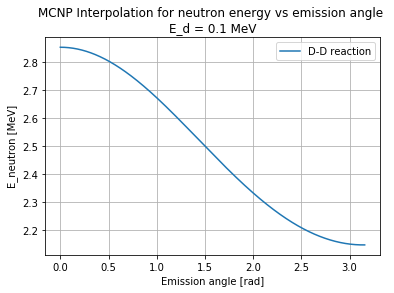

In [9]:
angle_start = 0.0
angle_stop = 180.0
angle_step = 10.0
energy = 0.1

angle_rad = list(map(np.cos,np.arange(angle_start,angle_stop + 1.0, angle_step)))
angle = np.arange(angle_start, angle_stop + 1.0, angle_step)
# convert to radian
angle = (angle / 360.0) * 2 * np.pi
mu = np.cos(angle) # this is the discretization chosen for the MCNP source probability

xRad,y,angle,intp_Y_av = fun_getNeutronEnergyVSEmissionAngle(energy, angle)


plt.plot(xRad,y,'-', label='D-D reaction')
plt.ylabel('E_neutron [MeV]')
plt.title('MCNP Interpolation for neutron energy vs emission angle ' + '\n' + 'E_d = '+str(energy) + ' MeV')
plt.xlabel('Emission angle [rad]')
plt.legend(loc='upper right')
# plt.ylim([1.0,2.9])
plt.grid(True)
plt.show()
